# Treetime Analysis

## Setup

---

### Module Imports

In [1]:
from Bio import Phylo
from treetime.utils import parse_dates
from treetime import wrappers

import copy
import os
import sys

import pandas
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors, lines, patches

### Input File Paths

In [2]:
'''
tree_path = str(snakemake.input.tree)
aln_path = str(snakemake.input.snp_aln)
metadata_path = str(snakemake.input.metadata)
treetime_path = str(snakemake.output.treetime)
'''
tree_path = "../../docs/results/2020-11-09/iqtree/iqtree-core_chromosome.filter5.treefile"
metadata_path = "../../docs/results/2020-12-08/metadata/metadata.txt"
outdir = "../../docs/results/2020-12-08/treetime/"

### Constants and Variables

In [3]:
NAME_COL = "Sample"
DATES_COL = "Date"
ATTRIBUTE = "Country"
#ATTRIBUTE = "Biovar"
MUG_CONF_THRESH = 0.90
MUG_CONF_RATIO = 2
NO_DATA_CHAR = "NA"
COLOR_PAL = "rainbow"
COLBAR_MAX_ROW = 10

### Convert Newick Tree to Temp XML

In [4]:
tmp_xml = os.path.join(os.path.dirname(tree_path), "temp.xml")
Phylo.convert(tree_path, "newick", tmp_xml, "phyloxml")

1

### Rename Internal Nodes and Parse Confidence

In [5]:
tree_div = Phylo.read(tmp_xml, "phyloxml")
# Deepest nodes first
tree_div.ladderize(reverse=True)

node_i = 0

for c in tree_div.find_clades():
    if not c.name:
        continue
    
    # Assuming IQTREE was run to have format aLRT/UFBoot.
    name_split = c.name.split("/")
    
    # If it's a terminal node
    if c.is_terminal():
        c.color = "grey"
    
    # Check if the name has 'accidentally' become the confidence vals
    if (
        len(name_split) == 2 
        and float(name_split[0]) >= 0 and float(name_split[1]) <= 100
        and float(name_split[1]) >= 0 and float(name_split[1])  <= 100
        ):

        # Name the internal node
        c.name = "NODE" + str(node_i)
        
        # Assign confidence values
        alrt_val = float(name_split[0])
        alrt_conf = Phylo.PhyloXML.Confidence(alrt_val, type="alrt")
        
        ufboot_val = float(name_split[1])
        ufboot_conf = Phylo.PhyloXML.Confidence(ufboot_val, type="ufboot")
        
        c.confidences.append(alrt_conf)
        c.confidences.append(ufboot_conf)
        
        c.color = "black"       
        # Strong branch support: alrt >= 80, UFboot >= 95
        if alrt_val >= 80 and ufboot_val >= 95:
            c.color = "red"
        
        # Increment node counter
        node_i += 1

### Draw the Tree Colored By Confidence

1

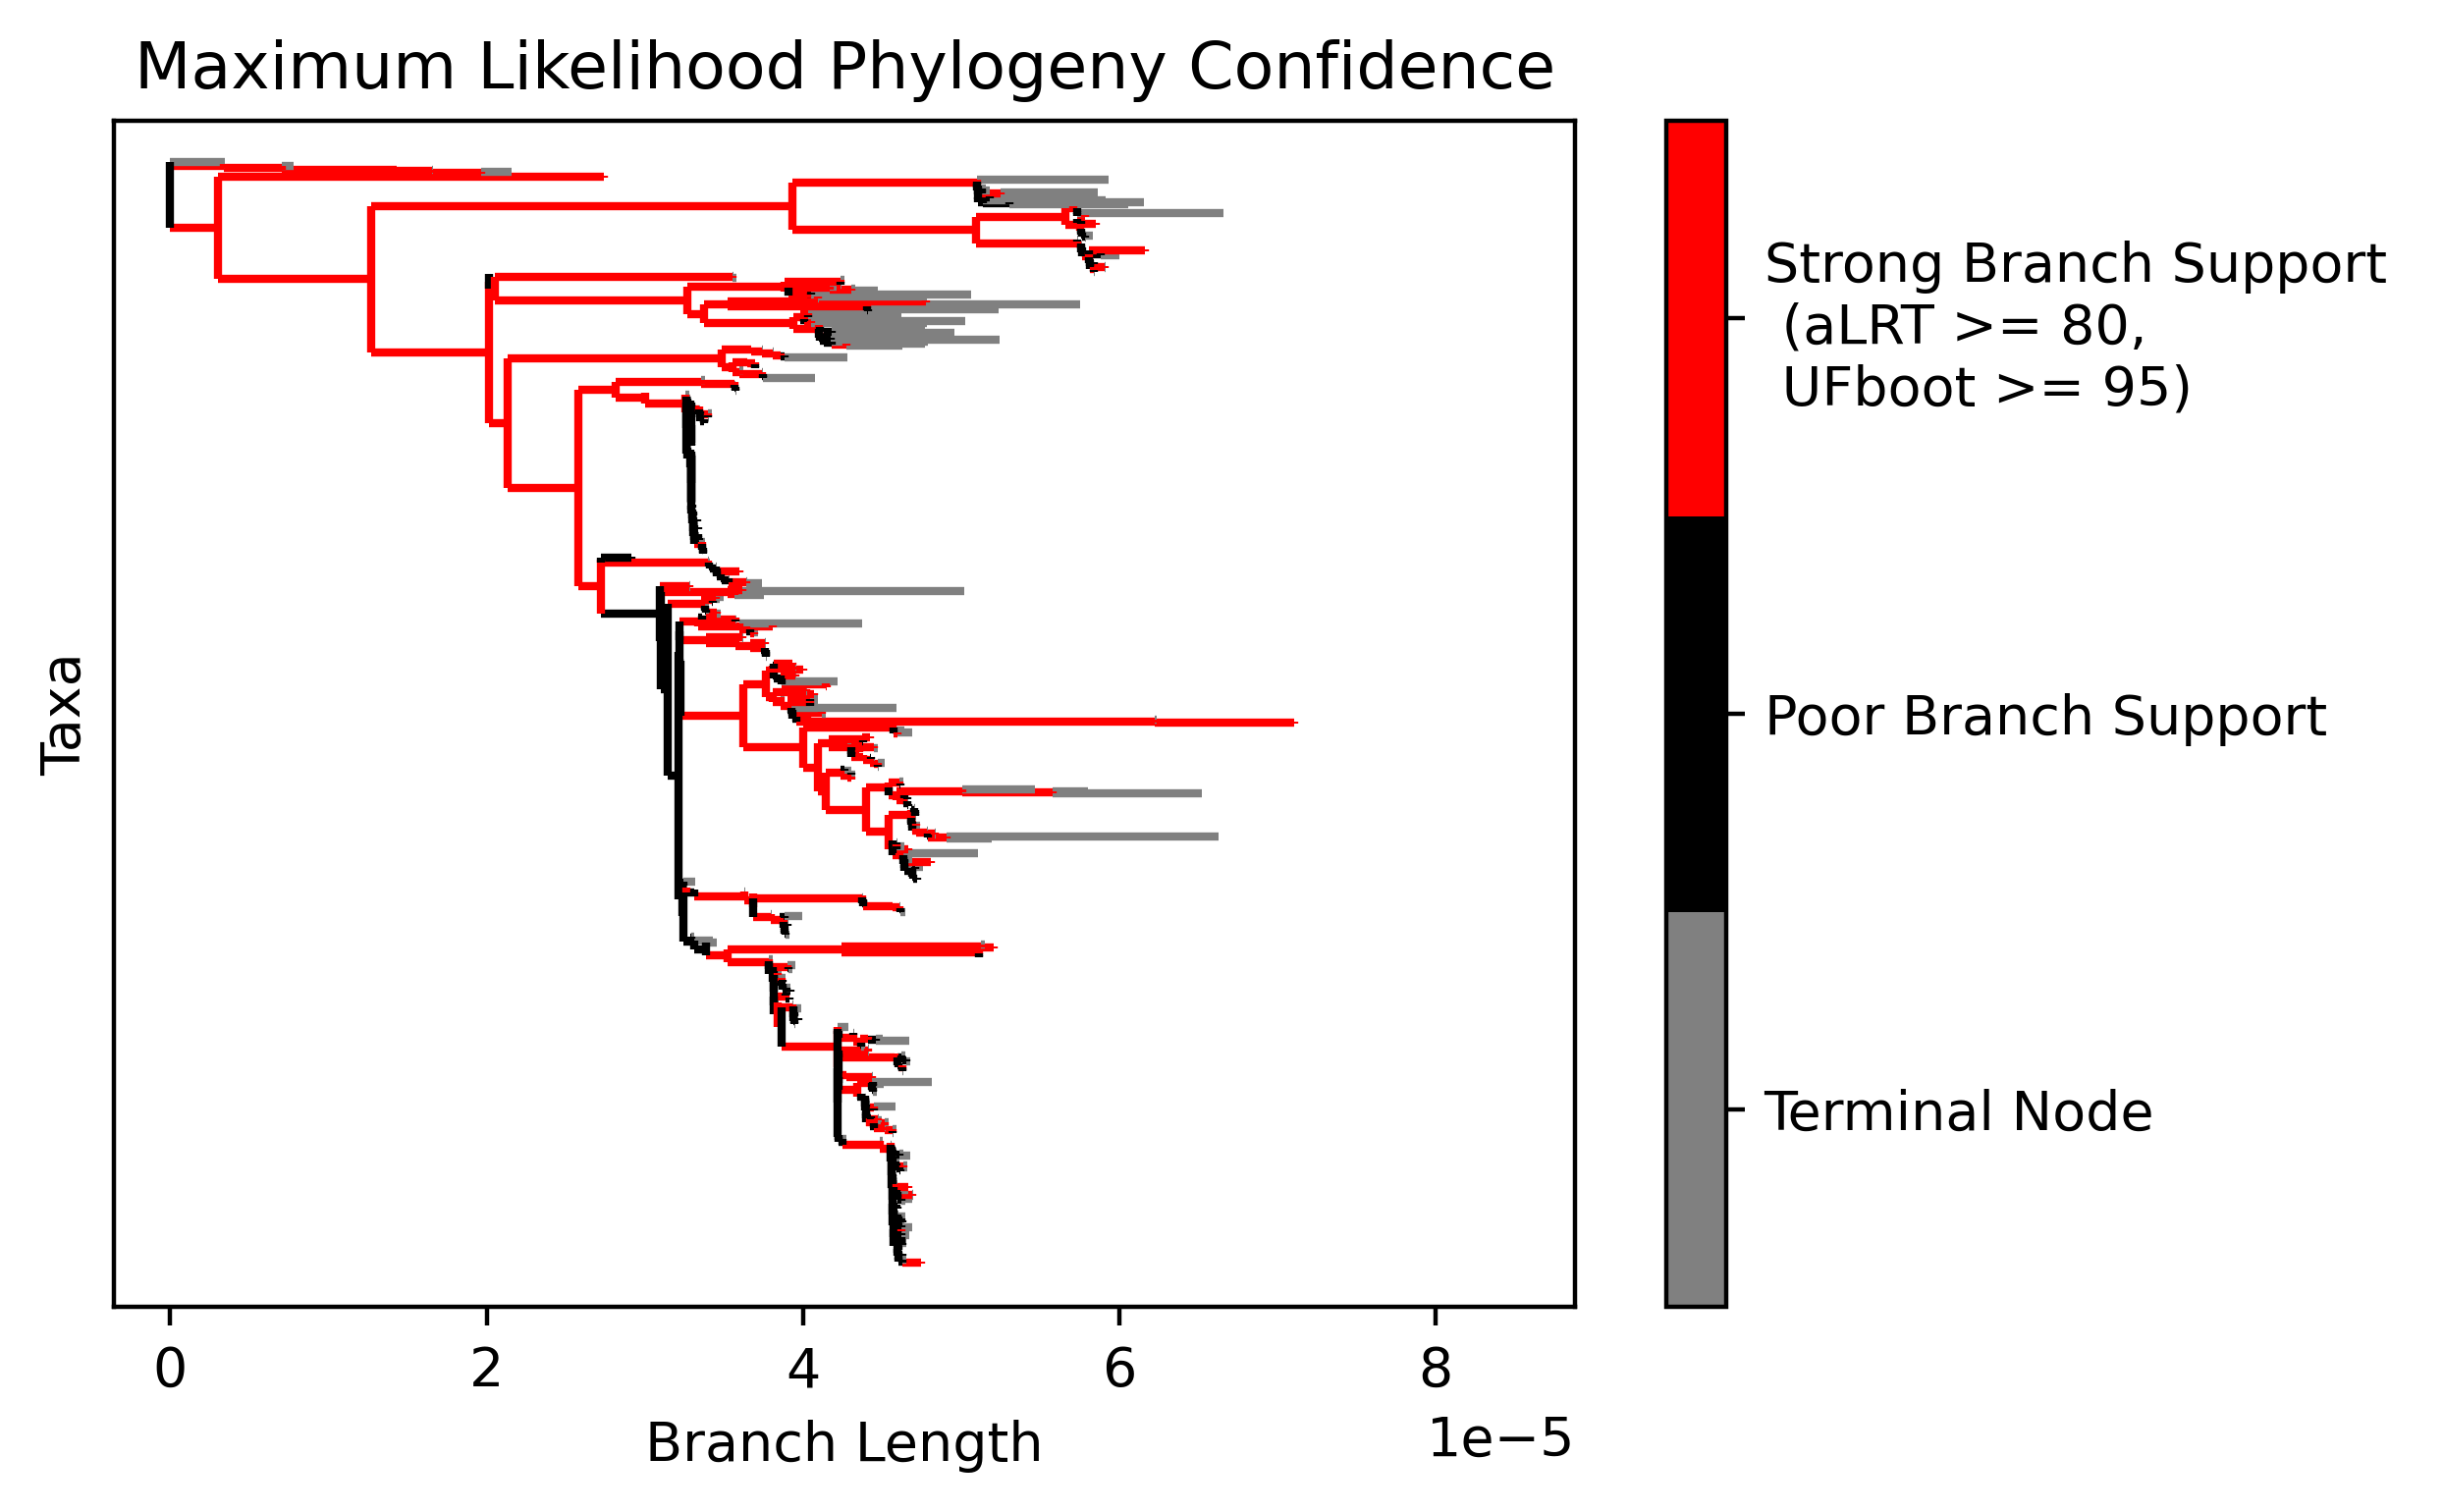

In [6]:
plt.figure(dpi=400)
ax = plt.subplot()

Phylo.draw(tree_div,
           axes=ax,
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
#ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(tree_div.get_terminals())+20)
ax.set_yticks([])

cmap = colors.ListedColormap(["grey","black","red"], name='conf_cmap', N=None)
norm = colors.Normalize(vmin=0.5,vmax=3.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(1,3,3))
cbar.ax.set_yticklabels(["Terminal Node",
                         "Poor Branch Support",
                         "Strong Branch Support \n (aLRT >= 80, \n UFboot >= 95)",]) 

plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Maximum Likelihood Phylogeny Confidence")

out_path = os.path.join(outdir, "treetime_confidence_tree.jpg") 
plt.savefig(out_path, dpi=400, bbox_inches = "tight")

# Write Tree File
out_path = os.path.join(outdir, "treetime_confidence_tree.xml" )
Phylo.write(tree_div, 
            out_path,
            "phyloxml")

In [7]:
# Sanity check
#for c in tree_div.find_clades():
#    print(c, c.name, c.branch_length, c.confidences)

### Parse Metadata

In [8]:
# Parse the metadata
states = pandas.read_csv(metadata_path, sep='\t')

# Tell treetime which column is the taxon name
if NAME_COL in states.columns:
    taxon_name = NAME_COL

# Tell treetime which column is the attribute for mugration
if ATTRIBUTE in states.columns:
    attr = ATTRIBUTE

# Get tips names
tree_tip_names = [t.name for t in tree_div.get_terminals()]

## Analysis

### Mugration Estimation

In [9]:
# Map the taxon name to the mugration attribute
leaf_to_attr = {x[taxon_name]:str(x[attr]) for xi, x in states.iterrows()
                    if x[attr]!=NO_DATA_CHAR and x[attr]}
print(leaf_to_attr)

# Optional: simplify the Mictorus biovar
for leaf in leaf_to_attr:
    leaf_attr = leaf_to_attr[leaf]
    if leaf_attr in ["Ulegeica", "Altaica", "Talassica", "Hissarica", "Xilingolensis", "Caucasica"]:
        leaf_to_attr[leaf] = "Microtus"

{'GCA_009669545.1_ASM966954v1_genomic': 'China', 'GCA_009669555.1_ASM966955v1_genomic': 'China', 'GCA_009669565.1_ASM966956v1_genomic': 'China', 'GCA_009669605.1_ASM966960v1_genomic': 'China', 'GCA_009669625.1_ASM966962v1_genomic': 'China', 'GCA_009669675.1_ASM966967v1_genomic': 'China', 'GCA_009669635.1_ASM966963v1_genomic': 'China', 'GCA_009669665.1_ASM966966v1_genomic': 'China', 'GCA_009669725.1_ASM966972v1_genomic': 'China', 'GCA_009669715.1_ASM966971v1_genomic': 'China', 'GCA_009669705.1_ASM966970v1_genomic': 'China', 'GCA_009669775.1_ASM966977v1_genomic': 'China', 'GCA_009669765.1_ASM966976v1_genomic': 'China', 'GCA_009669805.1_ASM966980v1_genomic': 'China', 'GCA_009669825.1_ASM966982v1_genomic': 'China', 'GCA_009669835.1_ASM966983v1_genomic': 'China', 'GCA_009669845.1_ASM966984v1_genomic': 'China', 'GCA_009669875.1_ASM966987v1_genomic': 'China', 'GCA_009669905.1_ASM966990v1_genomic': 'China', 'GCA_009669955.1_ASM966995v1_genomic': 'China', 'GCA_009669925.1_ASM966992v1_genomic': 

In [16]:
%%capture --no-stderr cap 

# Run the mugration (default nan comes from previous step)
out_path = os.path.join(outdir, "treetime_{}_mug.log".format(ATTRIBUTE.lower())) 
mug, letter_to_state, reverse_alphabet = wrappers.reconstruct_discrete_traits(tree=tree_div, 
                                                                     traits=leaf_to_attr, 
                                                                     missing_data="nan",
                                                                     #pc=pc, 
                                                                     #sampling_bias_correction=sampling_bias_correction, 
                                                                     verbose=4, 
                                                                     #weights=params.weights
                                                                    )
with open(out_path, 'w') as f:
    f.write(cap.stdout)

In [18]:
# All unique states from mugration
unique_states = sorted(letter_to_state.values())
print(unique_states)
#print(len(unique_states))

['Algeria', 'Armenia', 'Azerbaijan', 'Bolivia', 'Brazil', 'Canada', 'China', 'Croatia', 'Democratic Republic of the Congo', 'England', 'Estonia', 'France', 'Georgia', 'Germany', 'India', 'Indonesia', 'Iran', 'Kazakhstan', 'Kenya', 'Kyrgyzstan', 'Lithuania', 'Madagascar', 'Mongolia', 'Myanmar', 'Nepal', 'Norway', 'Peru', 'Russia', 'Spain', 'Switzerland', 'Tajikistan', 'The Netherlands', 'Turkmenistan', 'Uganda', 'United States of America', 'Uzbekistan', 'Zimbabwe', 'nan']


### Add Node Properties

ALL:  1078
HIGH CONFIDENCE:  1049 97.30983302411875
LOW CONFIDENCE:  29 2.6901669758812616


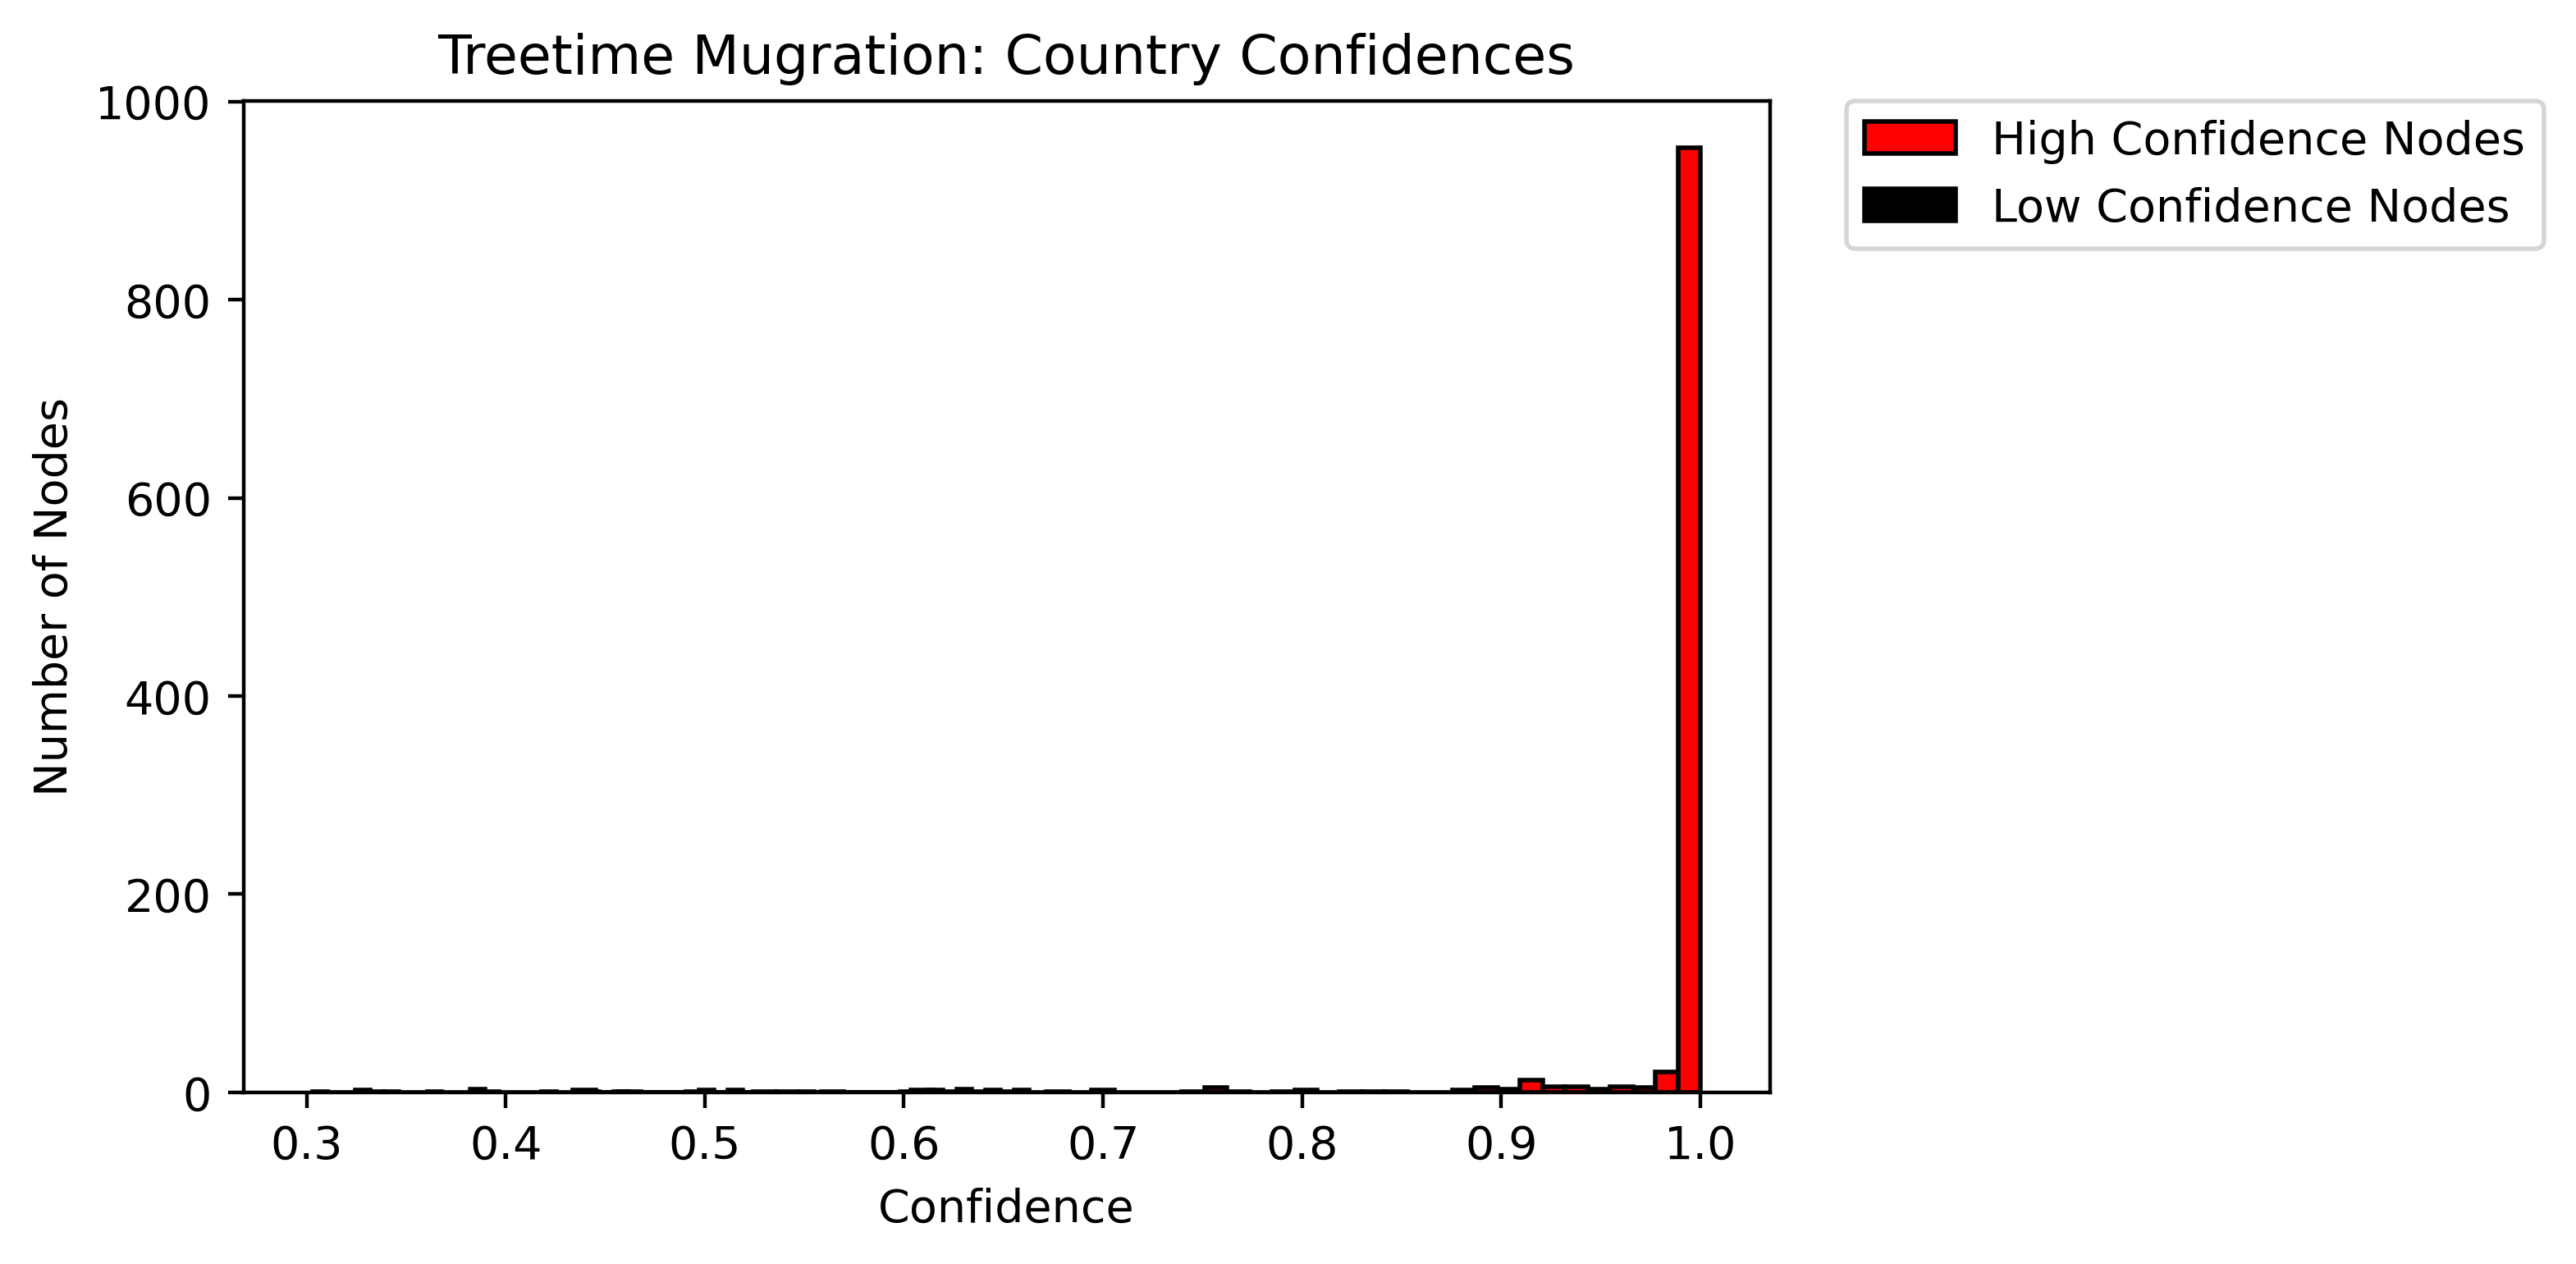

In [19]:
node_all_conf = {}
node_high_conf = {}
node_low_conf = {}

for c in mug.tree.find_clades():
    # Store the name and confidence for the state with the most support
    state_max_name = letter_to_state[c.cseq[0]]
    state_conf_list = c.marginal_profile[0]

    # Find the two largest values
    largest = 0
    second_largest = 0
    for conf in state_conf_list:
        if conf > largest:
            second_largest = largest
            largest = conf
        elif largest > conf > second_largest:
            second_largest = conf
        
    # Add the node value to the list
    node_all_conf[c.name] = largest
    
    c.other = []

    # Store all the states and confidence values
    for state_name,state_conf in zip(unique_states, state_conf_list):
        attr_other = Phylo.PhyloXML.Other(tag=state_name, value="{:0.4f}".format(state_conf), namespace=ATTRIBUTE)
        c.other.append(attr_other)
        
    # Option 1: Assign the maximum value based on threshold
    """
    if largest < MUG_CONF_THRESH:
        node_low_conf[c.name] = largest
        attr_other = Phylo.PhyloXML.Other(tag="Low Confidence", value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")
        
    else:
        node_high_conf[c.name] = largest
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")
    """
    # Option 2: Assign the maximum value based on ratio           
    if second_largest != 0 and (largest / second_largest < MUG_CONF_RATIO):
        node_low_conf[c.name] = largest
        attr_other = Phylo.PhyloXML.Other(tag="Low Confidence", value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")
                
    else:           
        node_high_conf[c.name] = largest
        attr_other = Phylo.PhyloXML.Other(tag=state_max_name, value="{:0.4f}".format(largest), namespace=ATTRIBUTE + "_assign")      
        
    c.other.append(attr_other)
        
print("ALL: ", len(node_all_conf))
print("HIGH CONFIDENCE: ", len(node_high_conf), len(node_high_conf)/len(node_all_conf) * 100)
print("LOW CONFIDENCE: ", len(node_low_conf), len(node_low_conf)/len(node_all_conf) * 100)

fig = plt.figure(dpi=400)
ax = plt.subplot()

#plt.hist(node_all_conf.values(), color = 'blue', edgecolor = 'black', bins=50, label="Confidence Distribution")
plt.hist(node_high_conf.values(), color = 'red', edgecolor = 'black', bins=50, label="High Confidence Nodes")
plt.hist(node_low_conf.values(), color = 'black', edgecolor = 'black', bins=50, label="Low Confidence Nodes")
#plt.axvline(x=MUG_CONF_THRESH, color="red", linestyle='--', label="Confidence Threshold")
plt.xlabel('Confidence')
plt.ylabel('Number of Nodes')


#blue_patch = patches.Patch(color='blue', label='Confidence Distribution')
#red_line = lines.Line(color='red', label='Confidence Threshold')
#plt.legend(handles=[blue_patch])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.title("Treetime Mugration: {} Confidences".format(ATTRIBUTE))
out_path = os.path.join(outdir, "treetime_{}_confidence_hist.jpg".format(ATTRIBUTE.lower())) 
plt.savefig(out_path, 
            dpi=400, 
            bbox_inches = "tight")


### Draw Mugration Tree

In [20]:
# Make a copy of the tree to edit values
mug_tree_div = copy.deepcopy(mug.tree)
# Deepest nodes first
mug_tree_div.ladderize(reverse=False)

# Initialize the states with the low confidence 
ordered_states = ["Low Confidence"]

# Get the ladderized order of attributes
for t in mug_tree_div.get_terminals():
    for prop in t.other:
        if prop.namespace == ATTRIBUTE + "_assign" and prop.tag not in ordered_states:
            ordered_states.append(prop.tag)

# Number of states that need colors (exclude nan)
num_attr = len(unique_states[:-1])

# Create the custom color map
cmap = plt.get_cmap(COLOR_PAL,num_attr)
# Convert to a list of colors
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the first color entry to be grey
cmaplist = [(.5, .5, .5, 1.0)] + cmaplist 
num_attr = num_attr + 1

# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, num_attr)

cmaplist = cmap(np.linspace(0, 1, num_attr))
hex_list = [colors.to_hex(col) for col in cmaplist]

hex_dict = {}

# Assign states colors based on tip order (Low Conf first as grey)
for state,hex_col in zip(ordered_states, hex_list):
    print(state,hex_col)
    hex_dict[state] = hex_col

# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

# Color branches by attr
for c in mug_tree_div.find_clades():
    for prop in c.other:
        if prop.namespace == ATTRIBUTE + "_assign":
            c.color = hex_dict[prop.tag]

Low Confidence #808080
Russia #8000ff
Lithuania #7116ff
Croatia #632cfe
Estonia #5542fd
Germany #4757fb
China #396cf9
Azerbaijan #2b7ff6
Armenia #1c92f3
Georgia #0ea4f0
Mongolia #00b4ec
Tajikistan #0ec3e7
Kyrgyzstan #1cd1e2
England #2adddd
Spain #39e7d7
France #47f0d1
Algeria #55f6ca
India #63fbc3
Nepal #71febc
Turkmenistan #80ffb4
Kazakhstan #8efeac
Uzbekistan #9cfba4
Iran #aaf69b
United States of America #b8f092
Norway #c6e789
Switzerland #d4dd80
The Netherlands #e3d176
Kenya #f1c36c
Democratic Republic of the Congo #ffb462
Uganda #ffa457
Zimbabwe #ff924d
Madagascar #ff8042
Myanmar #ff6c37
Indonesia #ff572c
Peru #ff4221
Canada #ff2c16
Brazil #ff160b
Bolivia #ff0000


1

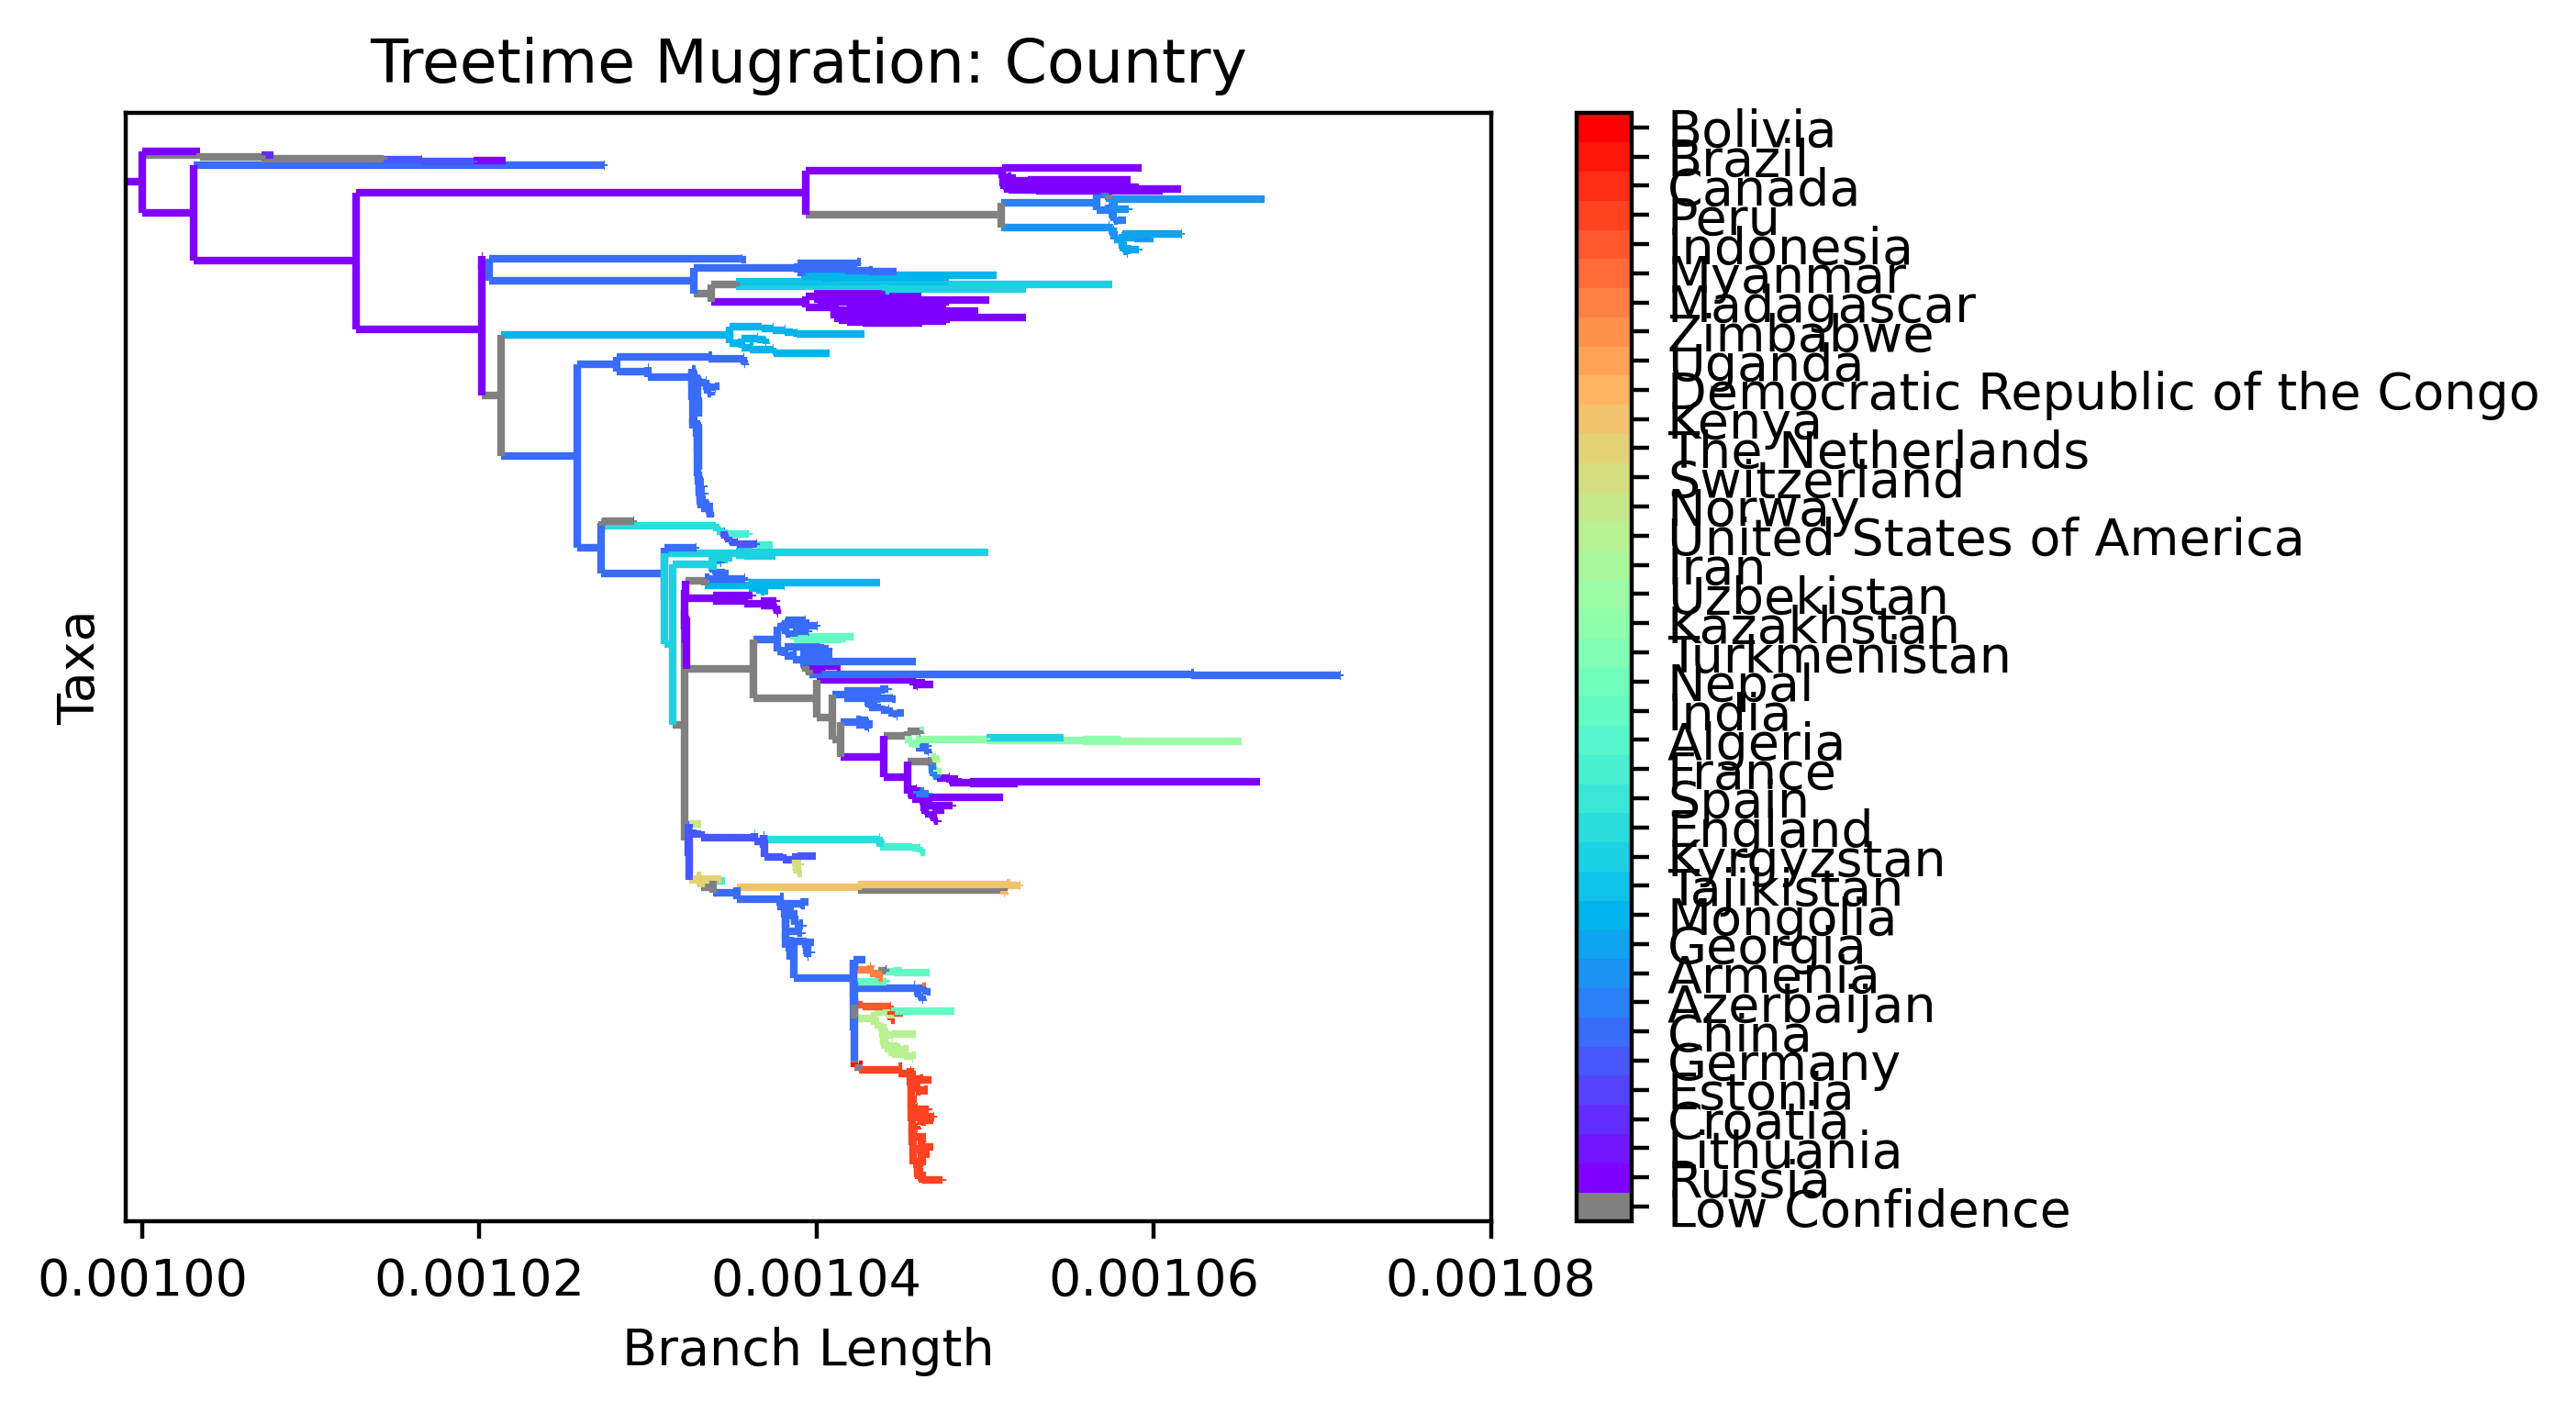

In [21]:
# Draw the tree
# ----------------------------------
# Deepest nodes last
mug_tree_div.ladderize(reverse=True)

fig = plt.figure(dpi=400)
ax = plt.subplot()

# Draw tree to the canvas
Phylo.draw(mug_tree_div, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# Root branch length set to 0.001
ax.set_xlim(0.000999,0.00108)
ax.set_ylim(-20,len(mug_tree_div.get_terminals())+20)
ax.set_yticks([])
#ax.set_xticks([])

# Create the colorbar
norm = colors.Normalize(vmin=0.5,vmax=num_attr + 0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(1,num_attr,num_attr))
# Add conf info to Low conf label
#ordered_states[0] = "Low Confidence \n (confidence < {})".format(MUG_CONF_THRESH)
ordered_states[0] = "Low Confidence"
cbar.ax.set_yticklabels(ordered_states) 

plt.xlabel("Branch Length")
plt.ylabel("Taxa")
plt.title("Treetime Mugration: {}".format(ATTRIBUTE))
out_path = os.path.join(outdir, "treetime_{}_mug_tree.jpg".format(ATTRIBUTE.lower()))  
plt.savefig(out_path, dpi=400, bbox_inches = "tight")

# Write Tree File
out_path = os.path.join(outdir, "treetime_{}_mug_tree.xml".format(ATTRIBUTE.lower() ))
Phylo.write(mug_tree_div, 
            out_path,
            "phyloxml")

## Cleanup

In [22]:
os.remove(tmp_xml)

FileNotFoundError: [Errno 2] No such file or directory: '../../docs/results/2020-11-09/iqtree/temp.xml'